# Fine-Tuning RoBERTa for Ad Detection in Text
This notebook provides a comprehensive workflow to fine-tune a pre-trained RoBERTa model on a binary text classification task. It covers data preparation, tokenization, model training, evaluation, visualization, and saving of the final model and tokenizer.

## Cell 1: Install Necessary Libraries  
- **Command:** Installs necessary libraries using pip in a Jupyter Notebook.
- **Libraries:**  
  - **datasets:** For handling datasets.
  - **transformers:** For using pre-trained NLP models.
  - **evaluate:** For model evaluation metrics.
- **Flag:** `--quiet` minimizes output verbosity.


In [1]:
# Cell 1: Install necessary libraries if not already available
!pip install datasets transformers evaluate --quiet


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00


## Cell 2: Import Libraries and Set Configurations  
- **Imports OS and JSON:** For interacting with the operating system and handling JSON data.
- **Numpy:** For numerical operations.
- **Datasets:**  
  - **Dataset, DatasetDict:** For managing data.
- **Evaluate:** For computing evaluation metrics.
- **Transformers:**  
  - **AutoTokenizer:** Tokenizes text for models.
  - **AutoModelForSequenceClassification:** Loads pre-trained classification models.
  - **TrainingArguments, Trainer:** Facilitate model training.
  - **DataCollatorWithPadding:** Handles dynamic padding of inputs.

In [2]:
# Cell 2: Import libraries and set any configurations

import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Datasets for handling data, Evaluate for metrics
from datasets import Dataset, DatasetDict
import evaluate

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)


## Cell 3: Data Setup  
- **Data Path Setup:**  
  - Defines `DATA_PATH` to point to the Kaggle input directory.
  - Constructs file paths for training, validation, and test responses and labels using `os.path.join`.
  
- **Function: `load_jsonl`:**  
  - Opens a JSONL file and reads it line-by-line.
  - Converts each non-empty line into a dictionary and returns a list of dictionaries.
  
- **Function: `merge_data`:**  
  - Loads responses and labels using `load_jsonl`.
  - Creates a mapping from response IDs to labels.
  - Merges responses with their corresponding labels (matching by ID) into a new list containing `id`, `text` (response), and `label`.
  
- **Merge Data:**  
  - Loads and merges responses with labels for training, validation, and testing using the `merge_data` function.


In [3]:
#Cell3 where data is set up
DATA_PATH = "/kaggle/input/touche-task4-2025-subtask2/touche-task4-2025-subtask2"
#sets the data paths oof file to variables
train_responses_file = os.path.join(DATA_PATH, "responses-train.jsonl")
train_labels_file = os.path.join(DATA_PATH, "responses-train-labels.jsonl")
val_responses_file = os.path.join(DATA_PATH, "responses-validation.jsonl")
val_labels_file = os.path.join(DATA_PATH, "responses-validation-labels.jsonl")
test_responses_file = os.path.join(DATA_PATH, "responses-test.jsonl")
test_labels_file = os.path.join(DATA_PATH, "responses-test-labels.jsonl")

#A function that Loads the JsonL file 
def load_jsonl(file_path):
    """Load a JSONL file and return a list of dicts."""
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if line:
                data.append(json.loads(line))
    return data
#This merges the data ,it merges the text and kabels by id and outputs id ,text and label in a list form
def merge_data(responses_file, labels_file):
    """Merge responses and labels using the response id."""
    responses = load_jsonl(responses_file)
    labels = load_jsonl(labels_file)
    label_map = {item["id"]: item["label"] for item in labels}
    
    merged = []
    for resp in responses:
        rid = resp["id"]
        if rid in label_map:
            merged.append({
                "id": rid,
                "text": resp["response"],
                "label": label_map[rid]
            })
    return merged


## Cell 4: Create Hugging Face Datasets  
- **Create Datasets:**  
  - Converts the merged data lists into Hugging Face `Dataset` objects.
  
- **Combine into DatasetDict:**  
  - Bundles the train, validation, and test datasets into a single `DatasetDict` for easier access.
  
- **Print Output:**  
  - Displays the resulting dataset structure.

In [4]:
# Cell 4: Create Hugging Face Datasets for train/validation/test

# Load and merge training data
train_data = merge_data(train_responses_file, train_labels_file)
val_data = merge_data(val_responses_file, val_labels_file)
test_data = merge_data(test_responses_file, test_labels_file)

# Create Dataset objects
train_dataset = Dataset.from_list(train_data)
val_dataset = Dataset.from_list(val_data)
test_dataset = Dataset.from_list(test_data)

# Combine into a DatasetDict for convenience
dataset = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

print(dataset)


DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 11487
    })
    validation: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['id', 'text', 'label'],
        num_rows: 2600
    })
})


## Cell 5: Tokenization  
- **Tokenizer Initialization:**  
  - Sets the model checkpoint to "roberta-base" and loads the corresponding tokenizer.
  
- **Tokenization Function:**  
  - Defines a function that tokenizes the "text" field of the examples with truncation enabled.
  
- **Apply Tokenization:**  
  - Uses the dataset's `map` method with `batched=True` to apply the tokenization function.
  - Removes the original "id" and "text" columns after tokenization, keeping only the tokenized data.


In [5]:
# Cell 5: Tokenize using RoBERTa tokenizer

model_checkpoint = "roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["id", "text"])


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/11487 [00:00<?, ? examples/s]

Map:   0%|          | 0/3257 [00:00<?, ? examples/s]

Map:   0%|          | 0/2600 [00:00<?, ? examples/s]

## Cell 6: Model and Data Collator Setup  
- **Model Initialization:**  
  - Loads a pre-trained RoBERTa model configured for sequence classification with 2 labels.
  
- **Data Collator:**  
  - Creates a collator that dynamically pads inputs in each batch to the length of the longest sequence.


In [6]:
# Cell 6: Create the model and data collator

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2)

# Data collator will dynamically pad the inputs to the longest item in a batch
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Cell 7: Trainer and Evaluation Metric Configuration  
- **Load Metrics:**  
  - Loads accuracy, precision, recall, and F1 metrics.
  
- **Define `compute_metrics`:**  
  - Computes predictions from logits.
  - Calculates accuracy, precision, recall, and F1 using binary averaging.
  
- **Set Training Arguments:**  
  - Configures training settings including output directory, evaluation strategy, learning rate, batch sizes, number of epochs, weight decay, logging steps, saving strategy, and selection of the best model based on F1 score.
  
- **Initialize Trainer:**  
  - Creates a `Trainer` instance with the model, training arguments, tokenized datasets, tokenizer, data collator, and metrics computation function.


In [7]:
# Cell 7: Define the evaluation metric and configure the Trainer

# Load evaluation metrics
accuracy_metric = evaluate.load("accuracy")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"]
    # For binary classification, we set average='binary'
    precision = precision_metric.compute(predictions=predictions, references=labels, average="binary")["precision"]
    recall = recall_metric.compute(predictions=predictions, references=labels, average="binary")["recall"]
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="binary")["f1"]
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}


#parameters set 
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-7-0d0c86486cfa>:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


## Cell 8: Train the Model  
**Train the model**  
- Initiates the training process with `trainer.train()`, fine-tuning the model on the training dataset.


In [8]:
# Cell 8: Train the model

trainer.train()


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.051200,0.048974,0.992017,0.994863,0.983080,0.988936
2,0.027200,0.029763,0.994473,0.994898,0.989848,0.992366


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=1436, training_loss=0.07960483604720417, metrics={'train_runtime': 1099.6734, 'train_samples_per_second': 20.892, 'train_steps_per_second': 1.306, 'total_flos': 4386947237107920.0, 'train_loss': 0.07960483604720417, 'epoch': 2.0})

## Cell 9: Evaluate on the Test Set  
**Evaluate on the test set**  
- Evaluates the fine-tuned model on the test dataset using `trainer.evaluate` and prints the evaluation metrics.


In [9]:
# Cell 9: Evaluate on the test set

test_metrics = trainer.evaluate(tokenized_datasets["test"])
print("Test set metrics:", test_metrics)


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test set metrics: {'eval_loss': 0.03484823927283287, 'eval_accuracy': 0.9934615384615385, 'eval_precision': 0.995575221238938, 'eval_recall': 0.9857612267250822, 'eval_f1': 0.9906439185470555, 'eval_runtime': 35.5748, 'eval_samples_per_second': 73.085, 'eval_steps_per_second': 4.582, 'epoch': 2.0}


## Cell 10: Save the Fine-Tuned Model and Tokenizer  
**Save the fine-tuned model and tokenizer**  
- Saves the model and tokenizer to the specified directory for future use.


In [10]:
# Cell 10: Save the fine-tuned model and tokenizer

model_save_path = "./roberta-ad-detector-finetuned"
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to ./roberta-ad-detector-finetuned


## Cell 11: Compute and Plot the Confusion Matrix  
**Compute and plot the confusion matrix for the test set**  
- Obtains predictions for the test set.
- Computes the confusion matrix by comparing true labels with predictions.
- Plots the confusion matrix using Seaborn.


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


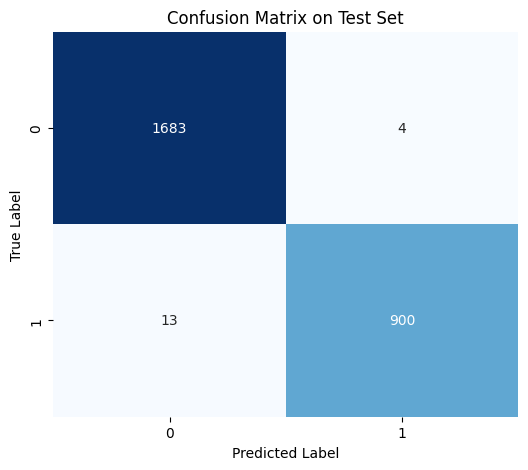

In [11]:
# Cell11: Compute and plot the confusion matrix for the test set

# Get predictions on the test set
test_output = trainer.predict(tokenized_datasets["test"])
predictions = test_output.predictions.argmax(axis=-1)
true_labels = test_output.label_ids

# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()


## Cell 12: Plot Training Loss  
**Extract training loss logs and plot average loss per epoch**  
- Extracts the training log history from the trainer’s state.
- Filters and groups loss values by epoch.
- Computes the average loss for each epoch.
- Plots the average training loss over the epochs.

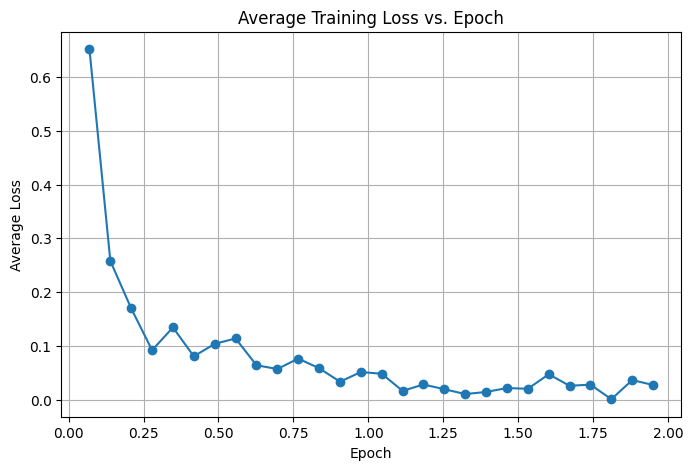

In [16]:
# Cell12: Extract training loss logs and plot average loss per epoch

# Get training log history from Trainer's state
log_history = trainer.state.log_history

# Filter out entries that include both "epoch" and "loss"
epoch_loss = {}
for entry in log_history:
    if "epoch" in entry and "loss" in entry:
        epoch = entry["epoch"]
        if epoch not in epoch_loss:
            epoch_loss[epoch] = []
        epoch_loss[epoch].append(entry["loss"])

# Compute the average loss for each epoch
epoch_loss_avg = {epoch: sum(losses) / len(losses) for epoch, losses in epoch_loss.items()}

# Sort the data by epoch
sorted_epochs = sorted(epoch_loss_avg.keys())
sorted_loss = [epoch_loss_avg[epoch] for epoch in sorted_epochs]

# Plot the average training loss per epoch
plt.figure(figsize=(8,5))
plt.plot(sorted_epochs, sorted_loss, marker="o", linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.title("Average Training Loss vs. Epoch")
plt.grid(True)
plt.show()
